Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

# Задание 3

## Классификация текстов

В этом задании вам предстоит попробовать несколько методов, используемых в задаче классификации, а также понять насколько хорошо модель понимает смысл слов и какие слова в примере влияют на результат.

In [2]:
import pandas as pd
import numpy as np
import torch
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

from sklearn.metrics import f1_score

from torchtext.legacy import datasets
from torchtext.legacy.data import BucketIterator
from torchtext.legacy.data import Field, LabelField
from torchtext.vocab import Vectors, GloVe

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from tqdm.autonotebook import tqdm

print("PyTorch Version: ", torch.__version__)

PyTorch Version:  1.10.0+cu111


В этом задании мы будем использовать библиотеку torchtext. Она довольна проста в использовании и поможет нам сконцентрироваться на задаче, а не на написании Dataloader-а.

In [ ]:
TEXT = Field(sequential=True, lower=True, include_lengths=True)  # Поле текста
LABEL = LabelField(dtype=torch.float)  # Поле метки

In [3]:
SEED = 1234
RANDOM_STATE = SEED
random.seed(SEED)
np.random.seed(SEED)
torch.random.manual_seed(SEED)
torch.cuda.random.manual_seed(SEED)
torch.cuda.random.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

BASE_DIR = Path('/content/drive/MyDrive/NLP/')

Датасет на котором мы будем проводить эксперементы это комментарии к фильмам из сайта IMDB.

In [ ]:
train, test = datasets.IMDB.splits(TEXT, LABEL)  # загрузим датасет
train, valid = train.split(random_state=random.seed(SEED))  # разобьем на части

downloading aclImdb_v1.tar.gz


100%|██████████| 84.1M/84.1M [00:07<00:00, 11.8MB/s]


In [ ]:
TEXT.build_vocab(train)
LABEL.build_vocab(train)

In [4]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')  
print(device)

CUDA is not available.  Training on CPU ...
cpu


In [ ]:
train_iter, valid_iter, test_iter = BucketIterator.splits(
    (train, valid, test), 
    batch_size = 64,
    sort_within_batch = True,
    device = device)

In [4]:
!nvidia-smi

Wed Apr 20 14:21:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    27W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## RNN

Для начала попробуем использовать рекурентные нейронные сети. На семинаре вы познакомились с GRU, вы можете также попробовать LSTM. Можно использовать для классификации как hidden_state, так и output последнего токена.

In [ ]:
class RNNBaseline(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):

        super().__init__()
        self.dropout = dropout

        # EMBEDDING layers
        self.embedding = nn.Embedding(num_embeddings = vocab_size, embedding_dim = embedding_dim, padding_idx = pad_idx)

        # LSTM layers
        self.rnn = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_dim, num_layers = n_layers, 
                           batch_first = False, dropout = dropout, bidirectional = bidirectional)

        # Fully connected layer
        if bidirectional:
          self.fc = nn.Linear(in_features = hidden_dim*2, out_features = output_dim)
        else:
          self.fc = nn.Linear(in_features = hidden_dim, out_features = output_dim)


    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        # cell arg for LSTM, remove for GRU
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)  

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        if bidirectional:
          hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)  # YOUR CODE GOES HERE
        else:
          hidden = hidden[-1,:,:]

        hidden = nn.Dropout(p=self.dropout)(hidden)

        #hidden = [batch size, hid dim * num directions] or [batch_size, hid dim * num directions]
            
        return self.fc(hidden)

Поиграйтесь с гиперпараметрами

In [ ]:
max_epochs = 30
vocab_size = len(TEXT.vocab)
emb_dim = 100
hidden_dim = 256
output_dim = 1
n_layers = 2
bidirectional = True
dropout = 0.35
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
patience=20
learning_rate = 1e-3
weight_decay = 6e-4

model = RNNBaseline(
    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    n_layers=n_layers,
    bidirectional=bidirectional,
    dropout=dropout,
    pad_idx=PAD_IDX
)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-8, weight_decay=weight_decay)
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)

Обучите сетку! Используйте любые вам удобные инструменты, Catalyst, PyTorch Lightning или свои велосипеды.

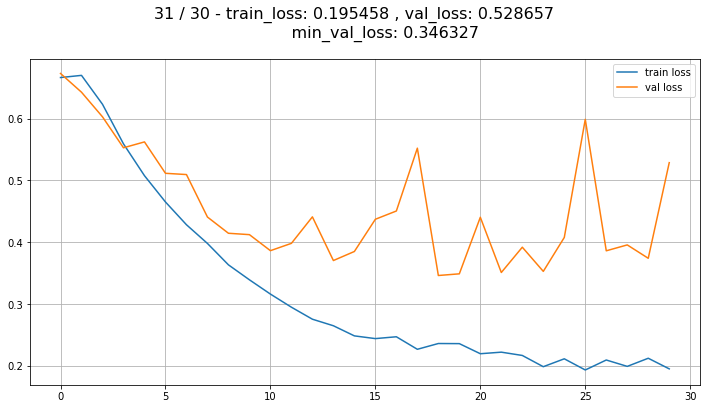

<All keys matched successfully>

In [ ]:
min_loss = np.inf
cur_patience = 0
train_loss_history = []
val_loss_history = []

for epoch in range(1, max_epochs + 1):
    train_loss = 0.0
    max_grad_norm = 1
    model.train()
    pbar = tqdm(enumerate(train_iter), total=len(train_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar: 
        #YOUR CODE GOES HERE
        optimizer.zero_grad()
        input_embeds = batch.text[0].to(device)
        embeds_lengths = batch.text[1].to(device).to('cpu')
        labels = batch.label.to(device)
        prediction = model(input_embeds, embeds_lengths)
        loss = criterion(prediction, labels.unsqueeze(1))
        train_loss += loss
        loss.backward()
        if max_grad_norm is not None:
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()

    train_loss /= len(train_iter)
    train_loss_history.append(train_loss.detach().cpu())
    scheduler.step()

    val_loss = 0.0
    model.eval()
    pbar = tqdm(enumerate(valid_iter), total=len(valid_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    with torch.no_grad():
      for it, batch in pbar:
        # YOUR CODE GOES HERE
        input_embeds = batch.text[0].to(device)
        embeds_lengths = batch.text[1].to('cpu')
        labels = batch.label.to(device)
        prediction = model(input_embeds, embeds_lengths)
        loss = criterion(prediction, labels.unsqueeze(1))
        val_loss += loss

    val_loss /= len(valid_iter)
    val_loss_history.append(val_loss.detach().cpu())
    if val_loss < min_loss:
        min_loss = val_loss
        best_model = model.state_dict()
        torch.save(best_model, Path(str(BASE_DIR) + str('/lstm_model')))
    else:
        cur_patience += 1
        if cur_patience == patience:
            cur_patience = 0
            break
    
    # Visualize tools
    clear_output(wait=True)
    fig = plt.figure(figsize=(12,6))
    fig.suptitle('%d / %d - train_loss: %f , val_loss: %f\n            min_val_loss: %f' % (epoch+1, max_epochs, train_loss, val_loss, min(val_loss_history)),
                     y=1, fontsize = 16)
    plt.plot(train_loss_history,label='train loss')
    plt.plot(val_loss_history,label='val loss')
    plt.grid()
    plt.legend(loc='best')
    plt.show()

model.load_state_dict(torch.load(Path(str(BASE_DIR) + str('/lstm_model')), map_location=device))

Посчитайте f1-score вашего классификатора на тестовом датасете.

**Ответ**:

In [ ]:
def make_f1_score(model, test_iter):
    model.eval()
    y_true = torch.tensor([])
    y_pred = torch.tensor([])
    pbar = tqdm(enumerate(test_iter), total=len(test_iter), leave=False)
    with torch.no_grad():
      for   _, batch in pbar:
        input_embeds = batch.text[0].to(device)
        embeds_lengths = batch.text[1].to('cpu')
        labels = batch.label.to(device)
        prediction = model(input_embeds, embeds_lengths)
        y_true = torch.cat((y_true, labels.cpu())) 
        y_pred = torch.cat((y_pred, torch.sigmoid(prediction).cpu()))

    test_f1 = f1_score(y_true.numpy(), y_pred.numpy() > 0.5, average='weighted')
    print(f'F1 Score: {round(test_f1,3)}')
    return None
    
make_f1_score(model, test_iter)

  0%|          | 0/391 [00:00<?, ?it/s]

F1 Score: 0.851


## CNN

![](https://www.researchgate.net/publication/333752473/figure/fig1/AS:769346934673412@1560438011375/Standard-CNN-on-text-classification.png)

Для классификации текстов также часто используют сверточные нейронные сети. Идея в том, что как правило сентимент содержат словосочетания из двух-трех слов, например "очень хороший фильм" или "невероятная скука". Проходясь сверткой по этим словам мы получим какой-то большой скор и выхватим его с помощью MaxPool. Далее идет обычная полносвязная сетка. Важный момент: свертки применяются не последовательно, а параллельно. Давайте попробуем!

In [7]:
TEXT = Field(sequential=True, lower=True, batch_first=True)  # batch_first тк мы используем conv  
LABEL = LabelField(batch_first=True, dtype=torch.float)

train, tst = datasets.IMDB.splits(TEXT, LABEL)
trn, vld = train.split(random_state=random.seed(SEED))

TEXT.build_vocab(trn)
LABEL.build_vocab(trn)

device = "cuda" if torch.cuda.is_available() else "cpu"

downloading aclImdb_v1.tar.gz


100%|██████████| 84.1M/84.1M [00:02<00:00, 30.6MB/s]


In [8]:
train_iter, valid_iter, test_iter = BucketIterator.splits(
        (trn, vld, tst),
        batch_sizes=(128, 256, 256),
        sort=False,
        sort_key= lambda x: len(x.src),
        sort_within_batch=False,
        device=device,
        repeat=False,
)

Вы можете использовать Conv2d с `in_channels=1, kernel_size=(kernel_sizes[0], emb_dim))` или Conv1d c `in_channels=emb_dim, kernel_size=kernel_size[0]`. Но хорошенько подумайте над shape в обоих случаях.

In [9]:
class CNN(nn.Module):
    def __init__(self, vocab_size, emb_dim, out_channels, kernel_sizes, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        
        self.conv_0 = nn.Conv1d(in_channels=emb_dim, 
                                out_channels=out_channels, 
                                kernel_size=kernel_sizes[0], 
                                padding=1, stride=2)
        
        self.conv_1 = nn.Conv1d(in_channels=emb_dim, 
                                out_channels=out_channels, 
                                kernel_size=kernel_sizes[1], 
                                padding=1, stride=2)
        
        self.conv_2 = nn.Conv1d(in_channels=emb_dim, 
                                out_channels=out_channels, 
                                kernel_size=kernel_sizes[2], 
                                padding=1, stride=2)
        
        self.fc = nn.Linear(len(kernel_sizes) * out_channels, 1)
        
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, text):
        
        embedded = self.embedding(text)  # [batch size, sent len, emb dim]
        
        embedded = embedded.permute(0, 2, 1)  # [batch size, emb dim, sent len]
        
        conved_0 = F.relu(self.conv_0(embedded))  # may be reshape here
        conved_1 = F.relu(self.conv_1(embedded))  # may be reshape here
        conved_2 = F.relu(self.conv_2(embedded))  # may be reshape here
        
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))
            
        return self.fc(cat)

In [10]:
kernel_sizes = [3, 4, 5]
vocab_size = len(TEXT.vocab)
out_channels=64
dropout = 0.35
dim = 100
max_epochs = 30
patience=20
learning_rate = 1e-3
weight_decay = 1e-6 #6e-4


model_cnn = CNN(vocab_size=vocab_size, emb_dim=dim, out_channels=out_channels, kernel_sizes=kernel_sizes, dropout=dropout)
model_cnn.to(device)

optimizer = torch.optim.Adam(model_cnn.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-8, weight_decay=weight_decay)
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)

Обучите!

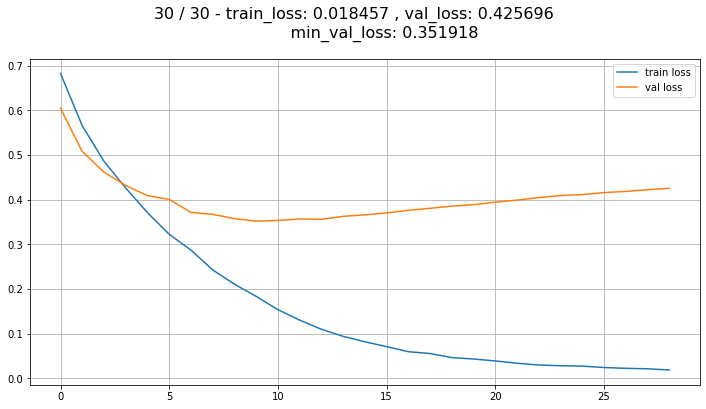

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

<All keys matched successfully>

In [11]:
min_loss = np.inf
cur_patience = 0
train_loss_history = []
val_loss_history = []

for epoch in range(1, max_epochs + 1):
    train_loss = 0.0
    max_grad_norm = 1
    model_cnn.train()
    pbar = tqdm(enumerate(train_iter), total=len(train_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar: 
        #YOUR CODE GOES HERE
        optimizer.zero_grad()
        input_embeds = batch.text.to(device)
        labels = batch.label.to(device)
        prediction = model_cnn(input_embeds)
        loss = criterion(prediction, labels.unsqueeze(1))
        train_loss += loss
        loss.backward()
        if max_grad_norm is not None:
          torch.nn.utils.clip_grad_norm_(model_cnn.parameters(), max_grad_norm)
        optimizer.step()

    train_loss /= len(train_iter)
    train_loss_history.append(train_loss.detach().cpu())
    scheduler.step()

    val_loss = 0.0
    model_cnn.eval()
    pbar = tqdm(enumerate(valid_iter), total=len(valid_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    with torch.no_grad():
      for it, batch in pbar:
        # YOUR CODE GOES HERE
        input_embeds = batch.text.to(device)
        labels = batch.label.to(device)
        prediction = model_cnn(input_embeds)
        loss = criterion(prediction, labels.unsqueeze(1))
        val_loss += loss

    val_loss /= len(valid_iter)
    val_loss_history.append(val_loss.detach().cpu())
    if val_loss < min_loss:
        min_loss = val_loss
        best_model_cnn = model_cnn.state_dict()
        torch.save(best_model_cnn, Path(str(BASE_DIR) + str('/cnn_model')))
    else:
        cur_patience += 1
        if cur_patience == patience:
            cur_patience = 0
            break
    
    # Visualize tools
    clear_output(wait=True)
    fig = plt.figure(figsize=(12,6))
    fig.suptitle('%d / %d - train_loss: %f , val_loss: %f\n            min_val_loss: %f' % (epoch+1, max_epochs, train_loss, val_loss, min(val_loss_history)),
                     y=1, fontsize = 16)
    plt.plot(train_loss_history,label='train loss')
    plt.plot(val_loss_history,label='val loss')
    plt.grid()
    plt.legend(loc='best')
    plt.show()

model_cnn.load_state_dict(best_model_cnn)

Посчитайте f1-score вашего классификатора.

**Ответ**:

In [12]:
def make_f1_score(model, test_iter):
    model.eval()
    y_true = torch.tensor([])
    y_pred = torch.tensor([])
    pbar = tqdm(enumerate(test_iter), total=len(test_iter), leave=False)
    with torch.no_grad():
      for   _, batch in pbar:
        input_embeds = batch.text.to(device)
        labels = batch.label.to(device)
        prediction = model(input_embeds)
        y_true = torch.cat((y_true, labels.cpu())) 
        y_pred = torch.cat((y_pred, torch.sigmoid(prediction).cpu()))

    test_f1 = f1_score(y_true.numpy(), y_pred.numpy() > 0.5, average='weighted')
    print(f'F1 Score: {round(test_f1,3)}')
    return None
    
make_f1_score(model_cnn, test_iter)

  0%|          | 0/98 [00:00<?, ?it/s]

F1 Score: 0.851


## Интерпретируемость

Посмотрим, куда смотрит наша модель. Достаточно запустить код ниже.

In [18]:
!pip install -q captum

     |████████████████████████████████| 1.4 MB 4.4 MB/s 


In [15]:
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization

PAD_IND = TEXT.vocab.stoi['pad']

token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)
lig = LayerIntegratedGradients(model_cnn, model_cnn.embedding)

In [21]:
def forward_with_softmax(inp):
    logits = model_cnn(inp)
    return torch.softmax(logits, 0)[0][1]

def forward_with_sigmoid(input):
    return torch.sigmoid(model_cnn(input))


# accumalate couple samples in this array for visualization purposes
vis_data_records_ig = []

def interpret_sentence(model, sentence, min_len = 7, label = 0):
    model.eval()
    text = [tok for tok in TEXT.tokenize(sentence)]
    if len(text) < min_len:
        text += ['pad'] * (min_len - len(text))
    indexed = [TEXT.vocab.stoi[t] for t in text]

    model.zero_grad()

    input_indices = torch.tensor(indexed, device=device)
    input_indices = input_indices.unsqueeze(0)
    
    # input_indices dim: [sequence_length]
    seq_length = min_len

    # predict
    pred = forward_with_sigmoid(input_indices).item()
    pred_ind = round(pred)

    # generate reference indices for each sample
    reference_indices = token_reference.generate_reference(seq_length, device=device).unsqueeze(0)

    # compute attributions and approximation delta using layer integrated gradients
    attributions_ig, delta = lig.attribute(input_indices, reference_indices, \
                                           n_steps=5000, return_convergence_delta=True)

    print('pred: ', LABEL.vocab.itos[pred_ind], '(', '%.2f'%pred, ')', ', delta: ', abs(delta))

    add_attributions_to_visualizer(attributions_ig, text, pred, pred_ind, label, delta, vis_data_records_ig)
    
def add_attributions_to_visualizer(attributions, text, pred, pred_ind, label, delta, vis_data_records):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()

    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions,
                            pred,
                            LABEL.vocab.itos[pred_ind],
                            LABEL.vocab.itos[label],
                            LABEL.vocab.itos[1],
                            attributions.sum(),       
                            text,
                            delta))

In [22]:
interpret_sentence(model_cnn, 'It was a fantastic performance !', label=1)
interpret_sentence(model_cnn, 'Best film ever', label=1)
interpret_sentence(model_cnn, 'Such a great show!', label=1)
interpret_sentence(model_cnn, 'It was a horrible movie', label=0)
interpret_sentence(model_cnn, 'I\'ve never watched something as bad', label=0)
interpret_sentence(model_cnn, 'It is a disgusting movie!', label=0)

pred:  pos ( 1.00 ) , delta:  tensor([9.6557e-05], device='cuda:0', dtype=torch.float64)
pred:  pos ( 0.95 ) , delta:  tensor([8.6445e-05], device='cuda:0', dtype=torch.float64)
pred:  pos ( 1.00 ) , delta:  tensor([3.8183e-05], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.09 ) , delta:  tensor([2.2550e-05], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.12 ) , delta:  tensor([8.1202e-05], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.03 ) , delta:  tensor([2.6355e-05], device='cuda:0', dtype=torch.float64)


Попробуйте добавить свои примеры!

In [35]:
interpret_sentence(model_cnn, 'The best revenge is massive success', label=1)
interpret_sentence(model_cnn, 'Don’t bother me, I living happily after', label=0)

pred:  pos ( 0.91 ) , delta:  tensor([0.0001], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.15 ) , delta:  tensor([9.3462e-05], device='cuda:0', dtype=torch.float64)


In [36]:
print('Visualize attributions based on Integrated Gradients')
visualization.visualize_text(vis_data_records_ig)

Visualize attributions based on Integrated Gradients


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
pos,pos (1.00),pos,0.83,It was a fantastic performance ! pad
pos,pos (0.95),pos,0.45,Best film ever pad pad pad pad
pos,pos (1.00),pos,0.75,Such a great show! pad pad pad
neg,neg (0.09),pos,-1.31,It was a horrible movie pad pad
neg,neg (0.12),pos,-1.12,I've never watched something as bad pad
neg,neg (0.03),pos,-1.31,It is a disgusting movie! pad pad
pos,pos (0.91),pos,0.03,The best revenge is massive success pad
pos,pos (0.91),pos,0.03,The best revenge is massive success pad
pos,pos (0.91),pos,0.03,The best revenge is massive success pad
pos,pos (0.91),pos,0.03,The best revenge is massive success pad


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
pos,pos (1.00),pos,0.83,It was a fantastic performance ! pad
pos,pos (0.95),pos,0.45,Best film ever pad pad pad pad
pos,pos (1.00),pos,0.75,Such a great show! pad pad pad
neg,neg (0.09),pos,-1.31,It was a horrible movie pad pad
neg,neg (0.12),pos,-1.12,I've never watched something as bad pad
neg,neg (0.03),pos,-1.31,It is a disgusting movie! pad pad
pos,pos (0.91),pos,0.03,The best revenge is massive success pad
pos,pos (0.91),pos,0.03,The best revenge is massive success pad
pos,pos (0.91),pos,0.03,The best revenge is massive success pad
pos,pos (0.91),pos,0.03,The best revenge is massive success pad


## Эмбеддинги слов

Вы ведь не забыли, как мы можем применить знания о word2vec и GloVe. Давайте попробуем!

In [6]:
TEXT = Field(sequential=True, lower=True, batch_first=True)  # batch_first тк мы используем conv  
LABEL = LabelField(batch_first=True, dtype=torch.float)

train, tst = datasets.IMDB.splits(TEXT, LABEL)
trn, vld = train.split(random_state=random.seed(SEED))

TEXT.build_vocab(trn, vectors=GloVe())# YOUR CODE GOES HERE

LABEL.build_vocab(trn)

word_embeddings = TEXT.vocab.vectors

kernel_sizes = [3, 4, 5]
vocab_size = len(TEXT.vocab)
dropout = 0.5
dim = 300

In [7]:
train_iter, valid_iter, test_iter = BucketIterator.splits(
        (trn, vld, tst),
        batch_sizes=(128, 256, 256),
        sort=False,
        sort_key= lambda x: len(x.src),
        sort_within_batch=False,
        device=device,
        repeat=False,
)

In [10]:
patience=5
max_epochs = 20
learning_rate = 1e-3
weight_decay = 1e-6 #6e-4

model_cnn_emb = CNN(vocab_size=vocab_size, emb_dim=dim, out_channels=64,
            kernel_sizes=kernel_sizes, dropout=dropout)

word_embeddings = TEXT.vocab.vectors

prev_shape = model_cnn_emb.embedding.weight.shape

with torch.no_grad():
    for i in range(len(word_embeddings)):
        model_cnn_emb.embedding.weight[i] = word_embeddings[i] # инициализируйте эмбэдинги

assert prev_shape == model_cnn_emb.embedding.weight.shape

optimizer = torch.optim.Adam(model_cnn_emb.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-8, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)
criterion = nn.BCEWithLogitsLoss()

In [11]:
model_cnn_emb.to(device)

CNN(
  (embedding): Embedding(201575, 300)
  (conv_0): Conv1d(300, 64, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv_1): Conv1d(300, 64, kernel_size=(4,), stride=(2,), padding=(1,))
  (conv_2): Conv1d(300, 64, kernel_size=(5,), stride=(2,), padding=(1,))
  (fc): Linear(in_features=192, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Вы знаете, что делать.

In [12]:
def freeze_embeddings(model, req_grad=False):
    embeddings = model.embedding
    for c_p in embeddings.parameters():
        c_p.requires_grad = req_grad

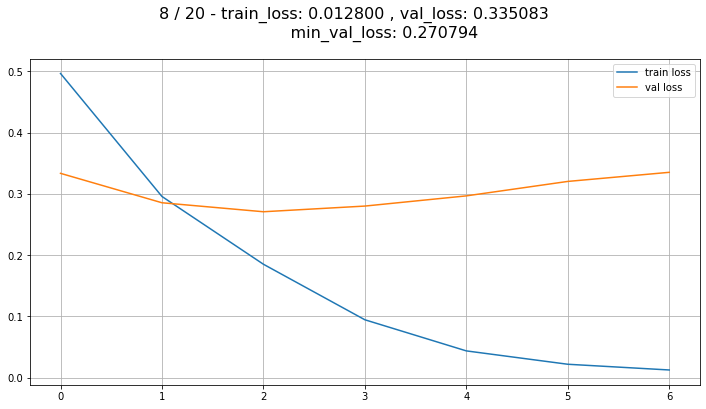

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

<All keys matched successfully>

In [14]:
min_loss = np.inf
cur_patience = 0
train_loss_history = []
val_loss_history = []
num_freeze_iter=1000

for epoch in range(1, max_epochs + 1):
    train_loss = 0.0
    max_grad_norm = 1
    model_cnn_emb.train()
    pbar = tqdm(enumerate(train_iter), total=len(train_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar: 
        #YOUR CODE GOES HERE
        if it > num_freeze_iter and epoch < 2:
          freeze_embeddings(model_cnn_emb, True)      
        optimizer.zero_grad()
        input_embeds = batch.text.to(device)
        labels = batch.label.to(device)
        prediction = model_cnn_emb(input_embeds)
        loss = criterion(prediction, labels.unsqueeze(1))
        train_loss += loss
        loss.backward()
        if max_grad_norm is not None:
          torch.nn.utils.clip_grad_norm_(model_cnn_emb.parameters(), max_grad_norm)
        optimizer.step()

    train_loss /= len(train_iter)
    train_loss_history.append(train_loss.detach().cpu())
    scheduler.step()

    val_loss = 0.0
    model_cnn_emb.eval()
    with torch.no_grad():
      pbar = tqdm(enumerate(valid_iter), total=len(valid_iter), leave=False)
      pbar.set_description(f"Epoch {epoch}")
      for it, batch in pbar:
          # YOUR CODE GOES HERE
          input_embeds = batch.text.to(device)
          labels = batch.label.to(device)
          prediction = model_cnn_emb(input_embeds)
          loss = criterion(prediction, labels.unsqueeze(1))
          val_loss += loss

    val_loss /= len(valid_iter)
    val_loss_history.append(val_loss.detach().cpu())
    if val_loss < min_loss:
        min_loss = val_loss
        best_model_cnn_emb = model_cnn_emb.state_dict()
        torch.save(best_model_cnn_emb, Path(str(BASE_DIR) + str('/cnn_emb_model')))
    else:
        cur_patience += 1
        if cur_patience == patience:
            cur_patience = 0
            break
    
    # Visualize tools
    clear_output(wait=True)
    fig = plt.figure(figsize=(12,6))
    fig.suptitle('%d / %d - train_loss: %f , val_loss: %f\n            min_val_loss: %f' % (epoch+1, max_epochs, train_loss, val_loss, min(val_loss_history)),
                     y=1, fontsize = 16)
    plt.plot(train_loss_history,label='train loss')
    plt.plot(val_loss_history,label='val loss')
    plt.grid()
    plt.legend(loc='best')
    plt.show()

model_cnn_emb.load_state_dict(best_model_cnn_emb)

Посчитайте f1-score вашего классификатора.

**Ответ**:

In [15]:
def make_f1_score(model, test_iter):
    model.eval()
    y_true = torch.tensor([])
    y_pred = torch.tensor([])
    pbar = tqdm(enumerate(test_iter), total=len(test_iter), leave=False)
    with torch.no_grad():
      for   _, batch in pbar:
        input_embeds = batch.text.to(device)
        labels = batch.label.to(device)
        prediction = model(input_embeds)
        y_true = torch.cat((y_true, labels.cpu())) 
        y_pred = torch.cat((y_pred, torch.sigmoid(prediction).cpu()))

    test_f1 = f1_score(y_true.numpy(), y_pred.numpy() > 0.5, average='weighted')
    print(f'F1 Score: {round(test_f1,3)}')
    return None
    
make_f1_score(model_cnn_emb, test_iter)

  0%|          | 0/98 [00:00<?, ?it/s]

F1 Score: 0.873


Проверим насколько все хорошо!

In [24]:
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization

def forward_with_softmax(inp):
    logits = model_cnn_emb(inp)
    return torch.softmax(logits, 0)[0][1]

def forward_with_sigmoid(input):
    return torch.sigmoid(model_cnn_emb(input))

PAD_IND = TEXT.vocab.stoi['pad']

token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)
lig = LayerIntegratedGradients(model_cnn_emb, model_cnn_emb.embedding)
vis_data_records_ig = []

interpret_sentence(model_cnn_emb, 'It was a fantastic performance !', label=1)
interpret_sentence(model_cnn_emb, 'Best film ever', label=1)
interpret_sentence(model_cnn_emb, 'Such a great show!', label=1)
interpret_sentence(model_cnn_emb, 'It was a horrible movie', label=0)
interpret_sentence(model_cnn_emb, 'I\'ve never watched something as bad', label=0)
interpret_sentence(model_cnn_emb, 'It is a disgusting movie!', label=0)

pred:  pos ( 1.00 ) , delta:  tensor([2.6973e-05], dtype=torch.float64)
pred:  neg ( 0.05 ) , delta:  tensor([3.3519e-05], dtype=torch.float64)
pred:  pos ( 0.95 ) , delta:  tensor([1.6761e-05], dtype=torch.float64)
pred:  neg ( 0.00 ) , delta:  tensor([1.7798e-05], dtype=torch.float64)
pred:  neg ( 0.33 ) , delta:  tensor([0.0001], dtype=torch.float64)
pred:  neg ( 0.00 ) , delta:  tensor([8.4138e-05], dtype=torch.float64)


In [25]:
print('Visualize attributions based on Integrated Gradients')
visualization.visualize_text(vis_data_records_ig)

Visualize attributions based on Integrated Gradients


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
pos,pos (1.00),pos,1.77,It was a fantastic performance ! pad
pos,neg (0.05),pos,1.23,Best film ever pad pad pad pad
pos,pos (0.95),pos,1.55,Such a great show! pad pad pad
neg,neg (0.00),pos,-0.51,It was a horrible movie pad pad
neg,neg (0.33),pos,1.40,I've never watched something as bad pad
neg,neg (0.00),pos,-1.08,It is a disgusting movie! pad pad


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
pos,pos (1.00),pos,1.77,It was a fantastic performance ! pad
pos,neg (0.05),pos,1.23,Best film ever pad pad pad pad
pos,pos (0.95),pos,1.55,Such a great show! pad pad pad
neg,neg (0.00),pos,-0.51,It was a horrible movie pad pad
neg,neg (0.33),pos,1.40,I've never watched something as bad pad
neg,neg (0.00),pos,-1.08,It is a disgusting movie! pad pad
